In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from dataset import DataMushroom
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
from torchvision.models import resnet34
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, random_split
from torchvision.transforms import ToTensor



ModuleNotFoundError: No module named 'PIL'

In [3]:
# Загрузка данных
df = pd.read_csv('E:\jupyter\Грибы\metadata\FungiTastic-FewShot\FungiTastic-FewShot-Train.csv')
# Выбор входных параметров X
X = df[['habitat', 'substrate', 'elevation', 'landcover', 'biogeographicalRegion', 'observationID','filename']]
# Выбор выходных параметров y 
y = df[['kingdom', 'phylum', 'class','order','category_id']]
data = DataMushroom(X,y)
print(data)
# Создаем загрузчик данных
train_loader = DataLoader(data, batch_size=2, shuffle=True)

СУПЕР ОСНОВНОЙ X
                                                habitat  \
0     Mixed woodland (with coniferous and deciduous ...   
1                                                garden   
2                                                garden   
3                                                garden   
4                                                garden   
...                                                 ...   
7814                                 Deciduous woodland   
7815                                 Deciduous woodland   
7816                       Unmanaged deciduous woodland   
7817                                        salt meadow   
7818                                        salt meadow   

                       substrate  elevation  landcover biogeographicalRegion  \
0     dead wood (including bark)        0.0       16.0           continental   
1     dead wood (including bark)        0.0       17.0           continental   
2     dead wood (including bark)  

In [4]:
for c in train_loader:
    print(c['x_data'].shape)
    print(c['y_data'].shape)
    print(c['images_tensor'].shape)
    print('-'*50)
    break

torch.Size([2, 5])
torch.Size([2, 5])
torch.Size([2, 10, 3, 224, 224])
--------------------------------------------------


In [5]:
# for i,c in enumerate(train_loader):
#     print(f"X_data shape: {c['x_data'].shape}")
#     print(f"y_data shape: {c['y_data'].shape}")
#     print(f"img shape: {c['images_tensor'].shape}")
#     print('-'*50)

In [6]:
# unique_counts = {}
# for c in data:
#     y = c['y_data']
#     # Обрабатываем все столбцы
#     for col in range(y.shape[0]):
#         unique_vals = torch.unique(y[col])
#         if col not in unique_counts:
#             unique_counts[col] = set()
#         unique_counts[col].update(unique_vals.tolist())
        
# unique_counts[0], unique_counts[3] = unique_counts[3], unique_counts[0]
# for col, vals in unique_counts.items():
#     print(f"Столбец {col}: {len(vals)} уникальных значений")

unique_counts = {}
for c in data:
    first_iteration = True
    y = c['y_data']
    # Обрабатываем все столбцы
    for col in range(y.shape[0]):
        if first_iteration:
            first_iteration = False
            continue
        unique_vals = torch.unique(y[col])
        if col-1 not in unique_counts:
            unique_counts[col-1] = set()
        unique_counts[col-1].update(unique_vals.tolist())
        
for col, vals in unique_counts.items():
    print(f"Столбец {col}: {len(vals)} уникальных значений")

Столбец 0: 3 уникальных значений
Столбец 1: 11 уникальных значений
Столбец 2: 33 уникальных значений
Столбец 3: 124 уникальных значений


In [9]:
!pip install higher

In [7]:

for col, vals in unique_counts.items():
    print(f"Столбец {col}: {len(vals)} уникальных значений")

Столбец 0: 3 уникальных значений
Столбец 1: 11 уникальных значений
Столбец 2: 33 уникальных значений
Столбец 3: 124 уникальных значений


In [8]:
class Custom(nn.Module):
    def __init__(self, base_model,unique_counts):
        super().__init__()
        self.ouputs = []
        self.unique_counts = unique_counts
        self.attention_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(513 + i, 256 + i),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256 + i, 513 + i),
                nn.Linear(513 + i, 513 + i)
            ) for i in range(5)
        ])
        # Предположим, у тебя 5 уровней иерархии
        self.hierarchy_layers = nn.ModuleList([
            nn.Linear(513 + i, len(self.unique_counts[i])) for i, counts in enumerate(unique_counts)
        ])
        self.cnn = (
            base_model.cnn if isinstance(base_model, Custom)
            else nn.Sequential(
                *list(base_model),
                nn.AdaptiveAvgPool2d((1, 1))
            )
        )
        
        self.attention = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )
        
        self.outlayer = nn.Sequential(
            nn.Linear(517,256),
            nn.ReLU(),
            nn.Linear(256,1),
            nn.ReLU()
        )
    def atteintion_img_patch(self, img_patch):
        stack_img = img_patch
        
        batch, num_img, channels, width, height = stack_img.size()
        features_img = stack_img.view(batch*num_img, channels, width, height)
        features_img_cnn = self.cnn(features_img)
        
        prepared_features = features_img_cnn.view(batch, -1, 512)
        attention_feature = self.attention(prepared_features)
        attention_softmax = F.softmax(attention_feature, dim=1)
        
        attention_weight = prepared_features * attention_softmax
        attention_weight_sum = attention_weight.sum(dim=1)
        print(attention_weight_sum.shape)
        return attention_weight_sum

    def additional_parameters(self, x_param, attention_img_features, i):
        attention_img_feature = attention_img_features
        for c in range(len(x_param.T)):
            if c == 5:
                return attention_img_feature
            unification = torch.cat((attention_img_feature, x_param.T[c].view(-1,1)), dim=1)
            attention_img_feature = self.attention_layers[c](unification)
            hierarchy_output = self.hierarchy_layers[c](attention_img_feature)
            self.ouputs.append(hierarchy_output)


    def forward(self, img_patch, parameters):
        self.ouputs = []
        attention_img = self.atteintion_img_patch(img_patch)
        reg = self.additional_parameters(parameters, attention_img, 0)
        x = self.outlayer(reg)
        return self.ouputs
        

resnet = resnet18(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-2])
model = Custom(resnet,unique_counts)

NameError: name 'resnet18' is not defined

In [32]:
print(model)

Custom(
  (attention_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=513, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=256, out_features=513, bias=True)
      (4): Linear(in_features=513, out_features=513, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=514, out_features=257, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=257, out_features=514, bias=True)
      (4): Linear(in_features=514, out_features=514, bias=True)
    )
    (2): Sequential(
      (0): Linear(in_features=515, out_features=258, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=258, out_features=515, bias=True)
      (4): Linear(in_features=515, out_features=515, bias=True)
    )
    (3): Sequential(
      (0): Linear(in_features=516, out_features=259, bias=True)
      (1): ReLU()
      (2): Dropout(p=

In [33]:
reg = [1,2,3,0]
der = [1,2,0,3]

In [34]:
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Импорт torchviz
from torchviz import make_dot

for epoch in range(10):
    running_loss = 0.0
    for d in train_loader:
        optimizer.zero_grad()
        img = d['images_tensor']
        x_data = d['x_data']
        y_data = d['y_data']

        output, ouputs = model(img, x_data)
        
        # Визуализация графа вычислений
        make_dot(output, params=dict(model.named_parameters())).render("model_graph", format="png")
        
        weights = [1/3, 1/11, 1/33, 1/2427]
        total_loss = 0
        for i, (level_reg, level_der) in enumerate(zip(reg, der)):
            preds = ouputs[level_der]
            loss = criterion(preds, y_data.T[level_reg].long())
            
            if i == len(reg) - 1:  # Проверяем последнюю итерацию цикла
                _, topk = preds.topk(10, dim=1)  # Получаем топ-10 предсказаний
                correct = topk.eq(y_data.T[level_reg].view(-1,1).expand_as(topk))  # Сравниваем с правильными ответами
                topk_acc = correct.sum().item() / len(y_data)  # Вычисляем точность
                print(f'Loss: {loss.item():.4f}, Top-10 Acc: {topk_acc:.4f}')  # Выводим loss и точность
            else:  # Для всех итераций кроме последней
                print(f'Loss: {loss.item():.4f}')
                
            total_loss += loss * weights[level_reg]
            
        total_loss.backward()
        optimizer.step()
        print(f'Total Loss: {total_loss.item():.4f}')

torch.Size([2, 512])
Loss: 2.4150
Loss: 3.6311


IndexError: Target 25 is out of bounds.

ValueError: Must pass 2-d input. shape=(7, 7, 3, 64)

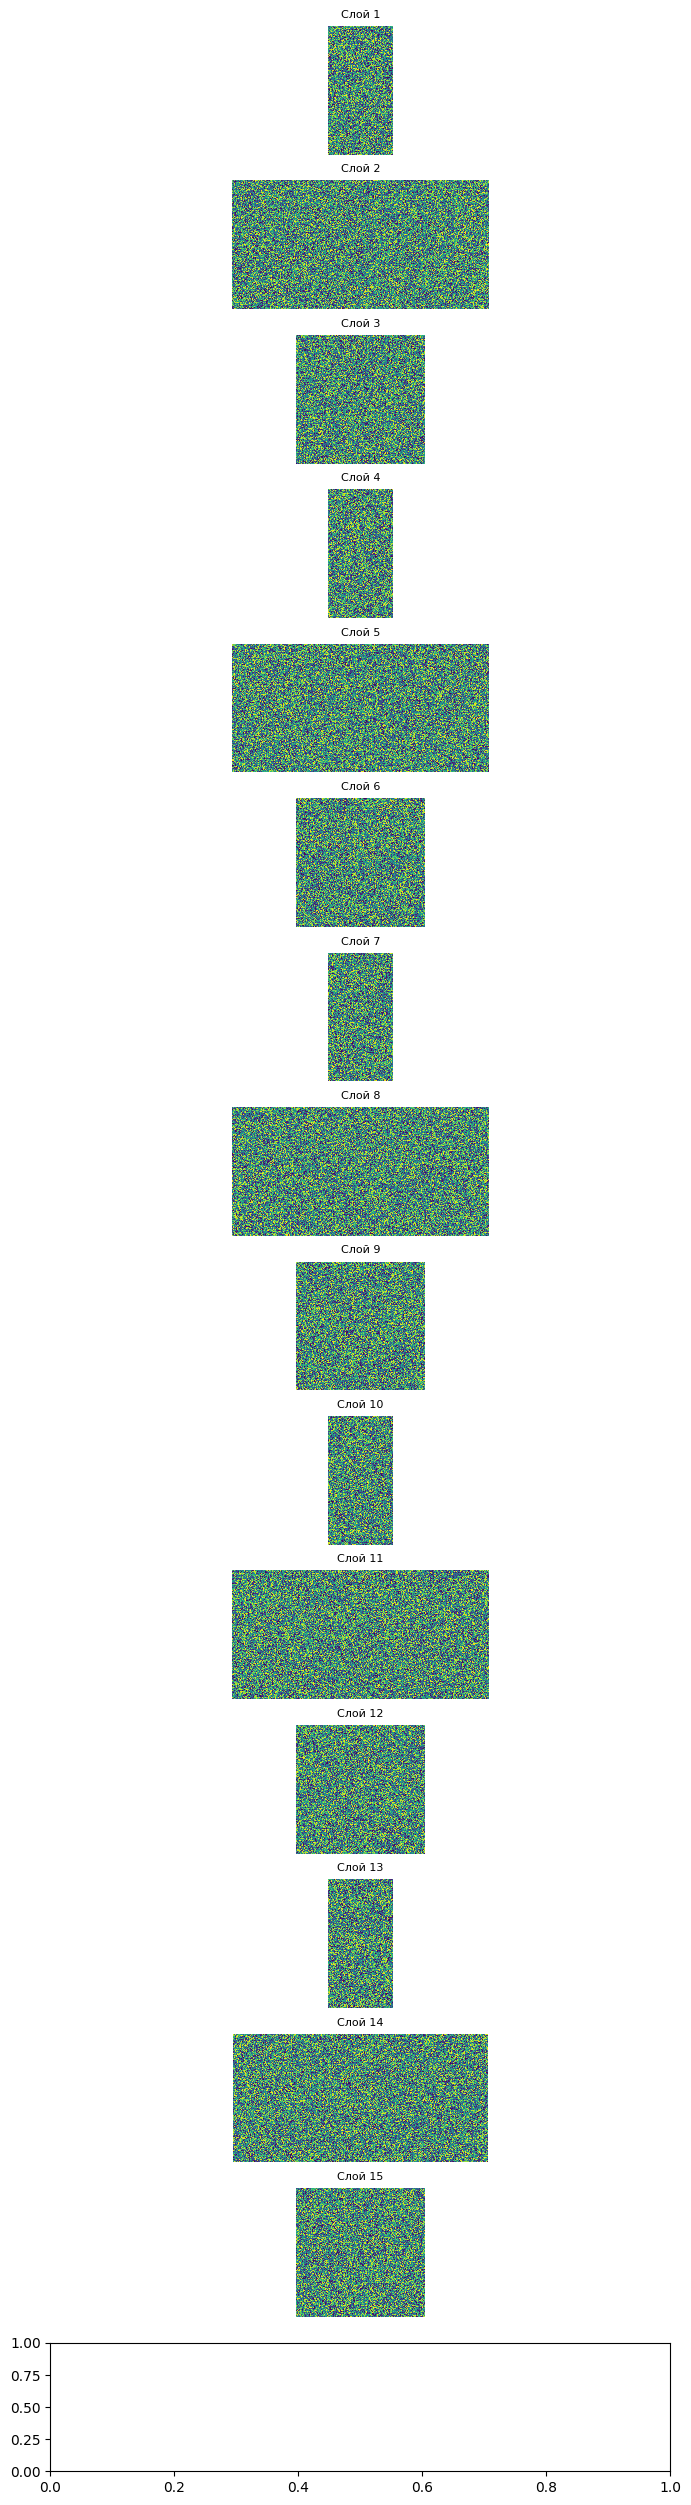

In [35]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Получаем веса модели
weights = []    
for name, param in model.named_parameters():
    if 'weight' in name:
        w = param.detach().cpu().numpy()
        if len(w.shape) > 1:
            w = w.T
        weights.append(w)

# Минимальный размер фигуры
n_layers = len(weights)
plt.figure(figsize=(8, 2 * n_layers))
for i, w in enumerate(weights):
    plt.subplot(n_layers, 1, i+1)
    sns.heatmap(w, cmap='viridis', annot=False, fmt='.2f',
                cbar=False,
                square=True,
                xticklabels=False,
                yticklabels=False)
    plt.title(f'Слой {i+1}', fontsize=8)
plt.tight_layout()
plt.show()


In [39]:
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Изменяем выходной слой для 32 классов
model.outlayer = nn.Sequential(
    nn.Linear(517, 512),
    nn.ReLU(),
    nn.Linear(512, 2426)  # 32 класса
)

# Для графика
epoch_losses = []

for epoch in range(10):
    running_loss = 0.0
    for d in data:
        optimizer.zero_grad()
        img = d['images_tensor']
        x_data = d['x_data']
        y_data = d['y_data'].T[:,0][0].view(-1).long()
        
        # Проверка на корректность меток
        if y_data.max() >= 2426 or y_data.min() < 0:
            print(f"Пропуск батча с некорректными метками: {y_data}")
            continue
            
        output,ouputs = model(img, x_data)
        
        # Проверяем, есть ли правильный класс в топ-5 предсказаний
        top5 = output.topk(5)[1]
        if y_data in top5:
            loss = torch.tensor(0.0, device=output.device, requires_grad=True)  # Добавляем requires_grad
        else:
            loss = criterion(output, y_data)
            
        loss.backward()
        optimizer.step()
        
        loss_value = loss.item()
        print(f'y_data: {y_data[0].item()}, output: {output.argmax(1)[0].item()}, top5: {top5[0].tolist()}, loss: {loss_value}')
        epoch_losses.append(loss.detach())  # Сохраняем без градиентов
    # print(f'Epoch {epoch+1}, Avg Loss: {avg_loss}')


AttributeError: 'tuple' object has no attribute 'topk'

In [161]:
# Нормализуем потери через softmax
import torch.nn.functional as F
epoch_losses = torch.sigmoid(torch.tensor(epoch_losses)).tolist()


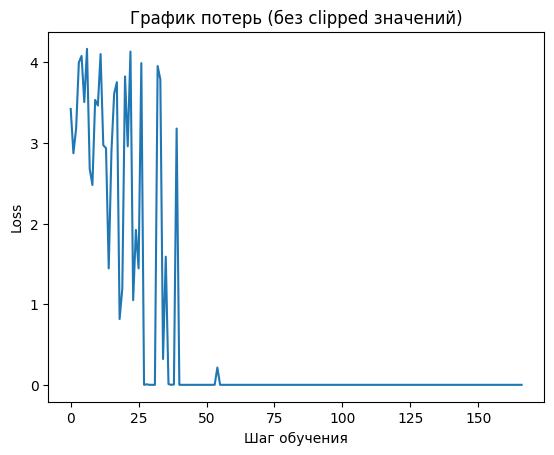

In [170]:
# Рисуем график, исключая loss = 5
import matplotlib.pyplot as plt
filtered_losses = [loss.detach().numpy() for loss in epoch_losses if loss.detach().numpy() < 5.0]
plt.plot(range(len(filtered_losses)), filtered_losses)
plt.xlabel('Шаг обучения')
plt.ylabel('Loss')
plt.title('График потерь (без clipped значений)')
plt.show()

In [48]:
# Определяем гиперпараметры
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10


Форма тензора: torch.Size([2, 2, 2])


In [49]:
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for d in data:
        x_train = d['x_data']
        img = d['images_tensor']
        y_data = d['y_data'][0].float().unsqueeze(0)  # Берем только первый экземпляр, преобразуем в float и добавляем размерность
        print(y_data)
        # Обнуляем градиенты
        optimizer.zero_grad()
        
        # Прямой проход
        outputs = model(img, x_train)
        
        # Вычисляем функцию потерь
        loss = criterion(outputs, y_data)
        
        # Обратное распространение
        loss.backward()
        
        # Оптимизация
        optimizer.step()
        
        running_loss += loss.item()
        print(running_loss)
    
    # Выводим среднюю потерю за эпоху
    epoch_loss = running_loss / len(data)
    print(f'Эпоха {epoch+1}/{num_epochs}, Потери: {epoch_loss:.4f}')

tensor([[2.4210e+03, 1.0000e+00, 1.0000e+00, 1.1000e+01]])
attention_weight_sum tensor([[0.9221, 0.9338, 0.9053, 0.9701, 0.9988, 0.8823, 0.8948, 1.1779, 0.9717,
         0.9679, 0.9024, 0.8307, 0.9903, 0.8833, 0.9465, 0.9499, 0.9226, 1.3537,
         0.9604, 0.8125, 0.8879, 1.0807, 0.9117, 1.0665, 0.8951, 0.9524, 0.9796,
         1.0217, 0.8870, 0.8555, 0.9506, 0.7839, 0.9691, 0.8803, 0.9253, 0.8467,
         0.9327, 0.9498, 0.8964, 0.9186, 0.8804, 0.9053, 0.8538, 0.9378, 0.8401,
         0.8704, 0.8906, 1.0982, 0.9733, 0.8903, 0.9285, 0.9045, 0.8441, 0.8155,
         0.9591, 0.9593, 1.1689, 0.8739, 0.9164, 1.0017, 0.8581, 0.9437, 0.9847,
         0.9815, 0.7418, 0.9707, 0.8157, 0.8546, 1.0004, 0.8961, 0.9282, 0.8297,
         0.9326, 0.8839, 0.9151, 0.8379, 0.9304, 0.8977, 0.9331, 0.8457, 0.9174,
         1.0339, 1.0753, 1.2782, 0.8392, 0.9522, 0.9563, 0.7447, 0.8987, 0.8243,
         0.8010, 0.9563, 0.8891, 0.8457, 0.8275, 0.8315, 0.9713, 0.9438, 0.8993,
         0.8661, 1.0673, 1.00

TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not NoneType

In [5]:
# Исходный тензор с формой (10, 3, 1, 1)
expanded_param = torch.randn(10, 3, 1, 1)

# Расширяем до (10, 3, 240, 240)
result = expanded_param.expand(-1, -1, 240, 240)

print("Исходная форма:", expanded_param)  # torch.Size([10, 3, 1, 1])
print("Новая форма:", result)    

Исходная форма: tensor([[[[ 1.1746]],

         [[-1.4089]],

         [[-0.3567]]],


        [[[-2.0994]],

         [[-0.5602]],

         [[-0.6238]]],


        [[[-0.7796]],

         [[ 1.3176]],

         [[ 0.4010]]],


        [[[ 0.3354]],

         [[ 0.9565]],

         [[-0.5290]]],


        [[[ 0.1972]],

         [[ 0.2292]],

         [[ 0.5302]]],


        [[[-0.3444]],

         [[-1.3209]],

         [[-1.1173]]],


        [[[-1.2505]],

         [[-0.2693]],

         [[-0.0982]]],


        [[[-0.8885]],

         [[-0.3858]],

         [[ 0.4821]]],


        [[[ 1.0204]],

         [[-0.0498]],

         [[-0.5802]]],


        [[[ 0.3428]],

         [[ 0.8945]],

         [[ 0.5881]]]])
Новая форма: tensor([[[[ 1.1746,  1.1746,  1.1746,  ...,  1.1746,  1.1746,  1.1746],
          [ 1.1746,  1.1746,  1.1746,  ...,  1.1746,  1.1746,  1.1746],
          [ 1.1746,  1.1746,  1.1746,  ...,  1.1746,  1.1746,  1.1746],
          ...,
          [ 1.1746,  1.1746,  1

In [15]:
for key in unique_counts.keys():
    print(key)



0
1
2
3


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

print("Инициализация модели и оптимизатора...")
# Простая модель
model = nn.Linear(1, 1)
print(f"Модель создана: {model}")

# Псевдоданные — синусоида с разными амплитудами и фазами
def get_batch(task):
    print("Генерация псевдоданных...")
    x = torch.rand(5, 1) * 2 * torch.pi
    y = task["amp"] * torch.sin(x + task["phase"])
    print(f"Сгенерировано X: {x.shape}, Y: {y.shape}")
    return x, y

# Пример задачи
task = {"amp": 2.0, "phase": 0.5}
print(f"Параметры задачи: {task}")

# Получаем данные
x, y = get_batch(task)
print(f"Получены данные: X={x}, Y={y}")

# Forward pass
print("Выполнение forward pass...")
pred = model(x)
print(f"Предсказания: {pred}")
loss = ((pred - y) ** 2).mean()
print(f"Loss: {loss.item()}")

# Получаем параметры модели как словарь
fast_weights = dict(model.named_parameters())
print(f"Параметры модели: {fast_weights}")

# Вычисляем градиенты с create_graph=True
print("Вычисление градиентов...")
grads = torch.autograd.grad(loss, fast_weights.values(), create_graph=True)
print(f"Градиенты вычислены: {grads}")

Инициализация модели и оптимизатора...
Модель создана: Linear(in_features=1, out_features=1, bias=True)
Параметры задачи: {'amp': 2.0, 'phase': 0.5}
Генерация псевдоданных...
Сгенерировано X: torch.Size([5, 1]), Y: torch.Size([5, 1])
Получены данные: X=tensor([[5.8068],
        [6.1026],
        [0.5577],
        [4.9223],
        [5.4475]]), Y=tensor([[ 0.0473],
        [ 0.6281],
        [ 1.7424],
        [-1.5169],
        [-0.6588]])
Выполнение forward pass...
Предсказания: tensor([[-2.8407],
        [-2.9952],
        [-0.0997],
        [-2.3788],
        [-2.6531]], grad_fn=<AddmmBackward0>)
Loss: 5.916477203369141
Параметры модели: {'weight': Parameter containing:
tensor([[-0.5222]], requires_grad=True), 'bias': Parameter containing:
tensor([0.1915], requires_grad=True)}
Вычисление градиентов...
Градиенты вычислены: (tensor([[-22.0063]], grad_fn=<TBackward0>), tensor([-4.4839], grad_fn=<ViewBackward0>))


In [16]:
unique_counts = {}
for c in data:
    first_iteration = True
    y = c['y_data']
    # Обрабатываем все столбцы
    for col in range(y.shape[0]):
        if first_iteration:
            first_iteration = False
            continue
        unique_vals = torch.unique(y[col])
        if col-1 not in unique_counts:
            unique_counts[col-1] = set()
        unique_counts[col-1].update(unique_vals.tolist())
        
for col, vals in unique_counts.items():
    print(f"Столбец {col}: {len(vals)} уникальных значений")

KeyboardInterrupt: 